In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from utils import (plot_datasets, plot_kmeans, train_kmeans, plot_initialization_analysis,
                   plot_kmeans_given_centroids, plot_gmm)

## Visualize the datasets (run the next cell)

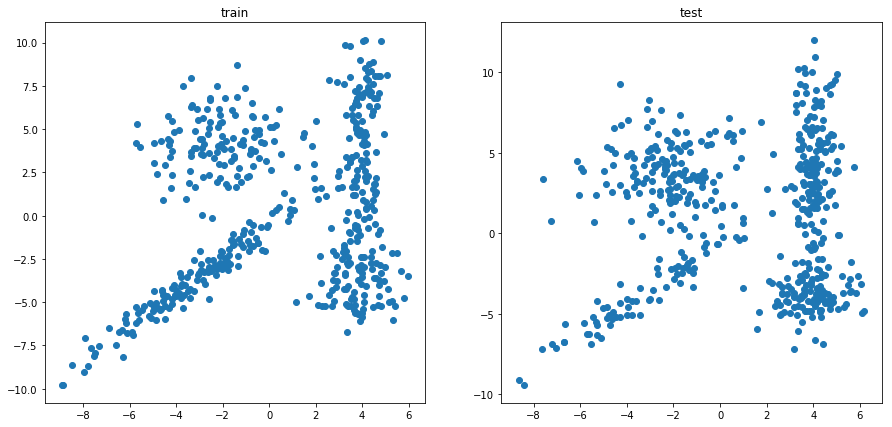

In [2]:
plot_datasets()

# a) k-means

In the next plot, different colors represent different cluster assignments. The centroids are initialized from a standard Gaussian. The stopping condition is: The difference between the new and old values of the objective function is lower than $\varepsilon = 10^{-4}$.

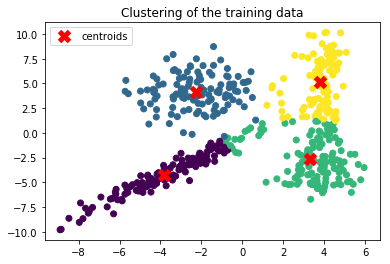

In [3]:
plot_kmeans(K=4)

Next, I try different random initializations (still from a standard Gaussian) of the centroids. In red, I show the mean of each of the 4 centroids (mean over N=100 random initialization). I also show the related **sample covariance matrices** (those tiny ellipses represents the boundaries of the areas of the plan that contain $99.5\%$ of the mass for each distribution). I show the empirical distribution of the final value of the objective function of k-means. 

I am cheating a little bit in this plot in that I take a small value of N (such that there are no "degenerate cases").

Obviously, given the randomness of the initialization, there are some initial centroids for which the k-means algorithm gives a bad a clustering (that's what I call degenerate case). This event has a low probability. This is why it's unlikely to stumble upon it with N=100. 

In the next plot, I increase N to make sure to have at least one degenerate case. Obviously, the corresponding covariance matrices are "wider", and the corresponding distribution of the final value of the objective function is also more elongated ! I also plot the cluster assignments / cluster centroids for one of those degenerate cases.

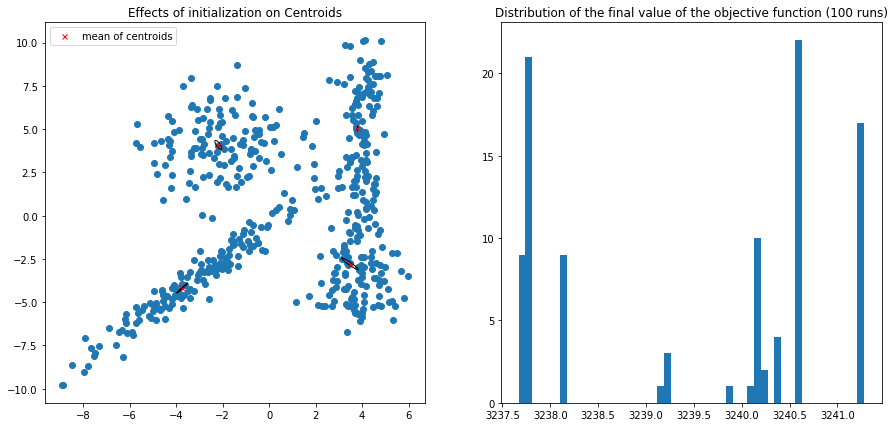

In [4]:
plot_initialization_analysis(4, N=100)

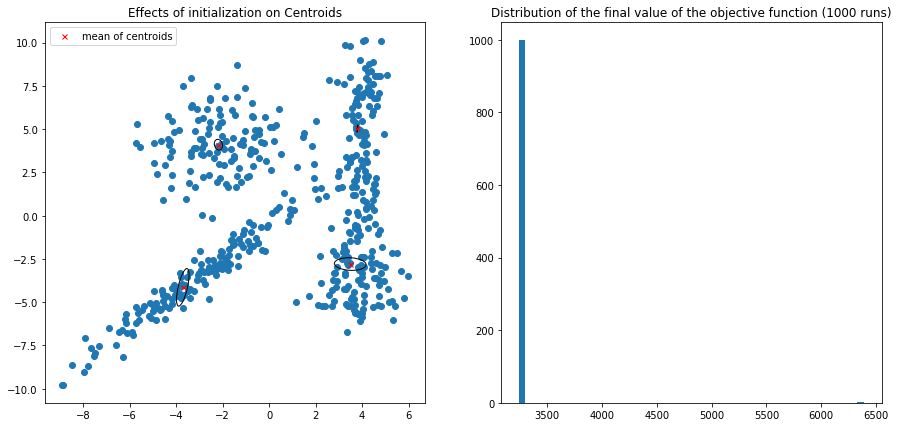

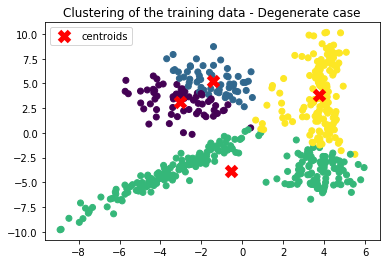

In [5]:
i = 0
while True:
    degenerate_centroids = plot_initialization_analysis(4, N=1000, return_degenerate=True)
    if degenerate_centroids is not None:
        break
    plt.clf()
plot_kmeans_given_centroids(degenerate_centroids)

# b) GMM with spherical covariance matrices

Let's derive the M step of the corresponding EM algorithm :

In the $(t+1)$-th M step, we maximize the lower-bound on the total log-likelhihood with respect to the parameters $\theta$: $\theta_{t+1} = argmax_\theta \mathbb{E}_{q_{t+1}(.)} \left[\sum_{i=1}^n \log p(x_i, . | \theta) \right]$, where $q_{t+1}(.)$ is the distribution obtained from the E step: $q_{t+1}(z) = p(z | x; \theta_t) \propto \prod_{i=1}^n \pi_{z_i}^t \mathcal{N}(x_i | \mu_{z_i}^t, \Sigma_{z_i}^t)$.

$\theta_{t+1} = argmax_\theta \mathbb{E}_{q_{t+1}(.)} \left[\sum_{i=1}^n \log p(x_i, . | \theta) \right] = argmax_\theta \sum_{i=1}^n \sum_{j=1}^K \mathbb{E}_{q_{t+1}(.)}[z_{i, j}] (\log \mathcal{N}(x_i | \mu_{j}, \Sigma_{j}) + \log \pi_j)$

Because $z_{i, j}$ takes values in $\{0, 1\}$, we have $\mathbb{E}_{q_{t+1}(.)}[z_{i, j}] = q_{t+1}(z_{i, j}=1) = \frac{\pi_j^t \mathcal{N}(x_i|\mu_{j}^t, \Sigma_{j}^t)}{\sum_{l=1}^K \pi_l^t \mathcal{N}(x_i|\mu_{l}^t, \Sigma_{l}^t)}$, which we will **denote hereinafter** as $\tau_{i, j}^t$.

Going back to the definitation of $\theta_{t+1}$, we get: $\theta_{t+1} = argmax_\theta L(\theta)$, where $L(\theta) = \sum_{i=1}^n \sum_{j=1}^K \tau_{i, j}^t (\log \mathcal{N}(x_i | \mu_{j}, \sigma^2_{j}) + \log \pi_j)$. Here, I made the **spherical covariance** assumption.

Note that there is an implicit constraint given that $\pi$ is the parameter of a Multinoulli distribution: $\sum_j \pi_j = 1$. The associated Lagrangian is $\mathcal{L}(\theta, \lambda) = L(\theta) - \lambda(\sum_j \pi_j - 1)$. 

$L(\theta) = \sum_{j=1}^K - d \frac{\sum_i \tau_{i, j}^t}{2} \log\sigma_j^2 + \sum_{i=1}^n \tau_{i, j}^t \left(\log \pi_j  - \frac{1}{2 \sigma_j^2} ||x_i - \mu_j||^2_2 \right)$

Some technicalities (it's not like you're reading this Gabi !) now. It is easy to see that:
- $\mathcal{L}$ is concave wrt all $\pi_j$. 
- Although we are supposed to optimize the Lagrangian, there are no constraints on the means and variances. For those, it would suffice to use first order methods on the function $L$.
- $L$ is concave wrt all $\mu_j$
- For the values of $\mu_j, \pi_j, \sigma_j^2$ that would be obtained by setting the respectivegradients of the Lagrangian (or $L$) to $0$ (see below), we can evaluate the Hessian at the "proposed optimum". Some tedious calculations would show that that Hessian is actually definite positive (we did this many times before). This shows that these values of the parameters actually correspond to the **only local maximum** of the function. 
- By evaluation $L$ on the boundaries of the set on which it's defined (infinities and zeros), we can easily conclude that the local maximum is a **global maximum**.
- To sum up: Trust me, setting the derivatives/gradients of $\mathcal{L}$ (or $L$) to 0 yield the actual argmax.

Setting $\frac{\partial \mathcal{L}(\theta, \lambda)}{\partial \pi_j} = 0$ yields $\pi_j = \frac{1}{\lambda} \sum_i \tau_{i, j}^t$. The constraint imposes that $1 = \frac{1}{\lambda} \sum_i \sum_j \tau_{i, j}^t$ i.e. $\lambda = n$. Hence the optimal value of $\pi$ is given by $\hat{\pi}_j = \frac{1}{n} \sum_i \tau_{i, j}^t$.

Setting $\frac{\partial L(\theta)}{\partial \mu_j} = 0$ yields $\sum_i \frac{\tau_{i, j}^t}{\sigma_j^2} (x_i - \mu_j) = 0$ i.e. $\hat{\mu}_j = \frac{\sum_i \tau_{i, j}^t x_i}{\sum_i \tau_{i, j}^t}$. 

Setting $\frac{\partial L(\theta)}{\partial \sigma^2_j} = 0$ yields $\hat{\sigma^2}_j = \frac{\sum_i \tau_{i, j}^t ||x_i - \hat{\mu_j}||_2^2}{d \sum_i \tau_{i, j}^t }$

Implementation-wise: The stopping condition is: $ ||\theta_{t+1} - \theta_t||_\infty \leq \varepsilon = 10^{-4}$.

In the following plot, for each cluster, the circle corresponds to the boundary of the area of the plan that contains $90\%$ of the mass of the corresponding Gaussian, which corresponds to approximately $2.15$ times the standard deviation (according to $\chi^2$ tables). Different colors represent different "cluster assignemnts" i.e. the most likely latent variables.

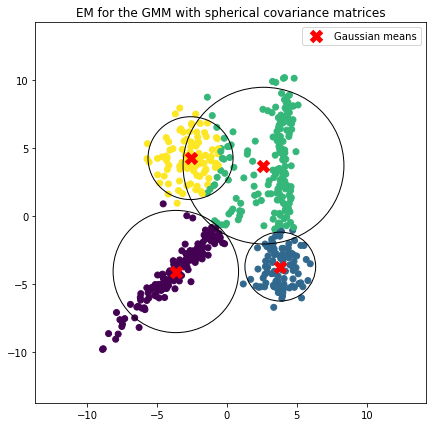

In [6]:
sphere_train_log_likelihood, sphere_test_log_likelihood = plot_gmm(K=4, spherical=True)

# c) GMM with general covariance matrices

Implementation-wise: The stopping condition is: $ ||\theta_{t+1} - \theta_t||_\infty \leq \varepsilon = 10^{-4}$.

In the following plot, for each cluster, the ellipse corresponds to the boundary of the area of the plan that contains $90\%$ of the mass of the corresponding Gaussian, which corresponds to approximately $2.15$ times the standard deviation along the corresponding ellipse axis (according to $\chi^2$ tables). Different colors represent different "cluster assignemnts" i.e. the most likely latent variables.

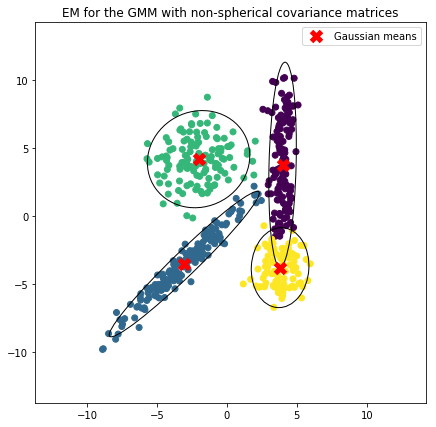

In [7]:
non_sphere_train_log_likelihood, non_sphere_test_log_likelihood = plot_gmm(K=4, spherical=False)

# d) Comments

Because we are able to observe the data, we can **see** that EM for GMM with general covariances suits the data best (compared to k-means and EM for GMM with spherical covariances). This can be justified by the fact that k-means, implicitly assumes spherical clusters given the $\mathbb{L}^2$ distance that's everywhere in the k-means algorithm.

It is obvious (conditionned on actually seeing the data ^^) that the 4 covariance matrices from which the data was generated are not spherical (except maybe for one, the top-left cluster). Meaning that making the sphericity assumption (either implicitly with k-means or explicitly in EM for GMM) is unlikely to retrieve the original clusters, as we actually observe.

Now we evaluate the average log-likelihood: $L = \frac{1}{n} \sum_{i=1}^n \sum_{j=1}^k \tau_{i, j} \left( \log \pi_{j} + \log \mathcal{N}(x_i | \mu_{j}, \Sigma_{j}) \right) = \frac{1}{n} \sum_{i=1}^n \sum_{j=1}^k \tau_{i, j} \left( \log \pi_{j} + \log \frac{1}{\sqrt{(2\pi)^d |\Sigma_j|}} - \frac{1}{2} (x_i - \mu_j)^T \Sigma_j^{-1} (x_i - \mu_j) \right)$

In [8]:
print('Spherical covariance matrices:\t train: {}\t test: {}\nGeneral covariance matrices:\t train: {}\t test: {}'.format(
    sphere_train_log_likelihood, sphere_test_log_likelihood, non_sphere_train_log_likelihood, non_sphere_test_log_likelihood
))


Spherical covariance matrices:	 train: -5.4785011129351355	 test: -5.437733394372973
General covariance matrices:	 train: -4.741765573355444	 test: -4.907123659618885


In particular, this shows that modelling the data with a GMM with general covariance matrices is more appropriate (Higher average log likelihood on both the train and the test set).

There is a slight decrease of the log likelihood on the test set in General Covariances case, which is normal given that that set wasn't use to evaluate the means and covariances of the distribution. But interestingly, the test log likelihood is higher than the train one for the spherical case. That might be explained by the fact that there are fewer datapoints around $(0, 0)$ in the test set (c.f. first figure with both the train and test data), which, according to the plot of question b, is the area that contains points that are the "least likely" given the model.